In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_phish = pd.read_csv("/content/drive/MyDrive/ProjetData354/Projet1/fishing-train.csv")

In [ ]:
df_phish.head(5)

,url,label
0,http://mylust.com/videos/198456/svelte-nympho-...,legit
1,http://serverfault.com/questions/676825/basic-...,legit
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing


# Analyse des données

In [ ]:
# Afficher le nombre de lignes et de colonnes de mon dataset
df_phish.shape

(23523, 2)

In [ ]:
# Afficher les dernières lignes du DataFrame
df_phish.tail()

,url,label
23518,http://buzzfil.net/article/5285/c-mignon/ce-ch...,legit
23519,http://kenh14.vn/doi-song/trao-luu-luon-song-c...,legit
23520,http://abcnews.go.com/US/wireStory/exterminato...,legit
23521,http://thenextweb.com/apps/2015/05/07/massive-...,legit
23522,http://themeforest.net/item/mist-30-business-e...,legit


In [ ]:
# renvoyer le décompte du nombre d'occurrences de chaque valeur unique dans la colonne 'label' du DataFrame
df_phish.label.value_counts()

legit      17688
fishing     5835
Name: label, dtype: int64

In [ ]:
# Afficher les colonnes
df_phish.columns

Index(['url', 'label'], dtype='object')

In [ ]:
# Information sur le DataFrame
df_phish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23523 entries, 0 to 23522
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     23523 non-null  object
 1   label   23523 non-null  object
dtypes: object(2)
memory usage: 367.7+ KB


À propos de l'ensemble de données nous avons 23523 entrées uniques.
Il y a deux colonnes, la colonne d'étiquette est une colonne de prédiction donc 2 catégories:
- `legit`, ce qui signifie que les URL ne contiennent pas d'éléments malveillants et que ce site n'est pas un phishing.

- `fishing` , ce qui signifie que les URL contiennent des éléments malveillants et que ce site est un site de phishing.

Il n'y a aucune valeur manquante dans l'ensemble de données.

In [ ]:
# compter le nombre de valeurs nulles dans chaque colonne du DataFrame
df_phish.isnull().sum()

url      0
label    0
dtype: int64

In [ ]:
# compter le nombre de valeurs dupliquées dans la colonne "url" du DataFrame.
df_phish.url.duplicated().sum()

0

<Axes: >

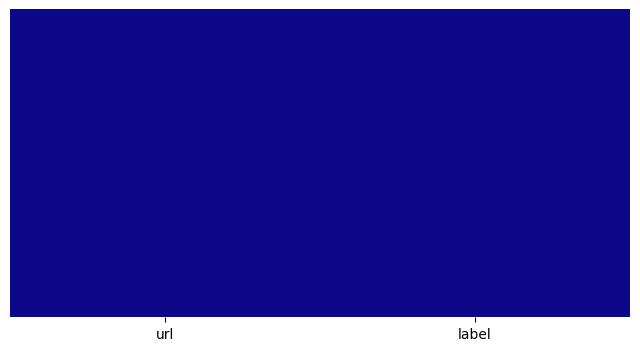

In [ ]:
# Créer une figure avec une taille de 8x4 pouces
plt.figure(figsize=(8, 4))

# Créer une carte thermique (heatmap) pour visualiser les valeurs nulles dans le DataFrame df_phish
# yticklabels=False : Ne pas afficher les étiquettes sur l'axe des y
# cbar=False : Ne pas afficher la barre de couleur sur le côté
# cmap='plasma' : Utiliser la palette de couleurs 'plasma'
sns.heatmap(df_phish.isnull(), yticklabels=False, cbar=False, cmap='plasma')


In [ ]:
# Affiche les statistiques descriptives du DataFrame df_phish
df_phish.describe()

,url,label
count,23523,23523
unique,23523,2
top,http://mylust.com/videos/198456/svelte-nympho-...,legit
freq,1,17688


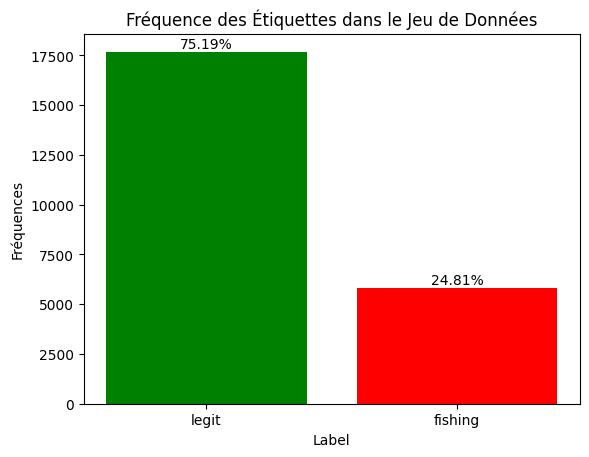

In [ ]:
# Extraction de la colonne des étiquettes du DataFrame
labels = df_phish.label

# Création d'un nouveau DataFrame à partir de la colonne des étiquettes
labels = pd.DataFrame(labels)

# Calcul de la fréquence et du pourcentage des différentes étiquettes
labels_count = labels["label"].value_counts()
labels_percentage = labels_count / len(labels) * 100

# Affichage de la fréquence des étiquettes sous forme de diagramme à barres avec le pourcentage
fig, ax = plt.subplots()
bars = ax.bar(labels_count.index, labels_count.values, color=['green', 'red'])

# Ajout des étiquettes de pourcentage au-dessus des barres
for bar, percentage in zip(bars, labels_percentage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%',
            ha='center', va='bottom', fontsize=10, color='black')

# Configuration du diagramme
ax.set_xlabel("Label")  # Axe des x : Étiquettes
ax.set_ylabel("Fréquences")  # Axe des y : Fréquences
ax.set_title("Fréquence des Étiquettes dans le Jeu de Données")  # Titre du diagramme
plt.show()

### Remplacer les étiquettes

In [ ]:
# legit: 0 et fishing: 1
df_phish.replace({'legit':0, 'fishing':1}, inplace=True)

# Prétraitement

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Télécharger les stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

La fonction `preprocess_initial` effectue la tokenization et la racinisation initiales sur une URL. Elle utilise un tokenizer pour diviser l'URL en mots, un stemmer pour réduire les mots à leur racine, et elle supprime ensuite les stopwords spécifiques aux URL. Enfin, elle concatène les mots résultants pour former une version traitée de l'URL.

In [ ]:
def preprocess_initial(url):
    """
    Fonction pour effectuer la tokenization et la racinisation initiales sur une URL.

    Parameters:
    - url: URL à traiter.

    Returns:
    - Texte tokenisé et racinisé.
    """

    # Créer le tokenizer
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')

    # Appliquer la tokenization à l'URL
    text_tokenise = tokenizer.tokenize(url)

    # Créer le stemmer
    stemmer = SnowballStemmer("english")

    # Appliquer la racinisation à l'URL
    text_stemmed = [stemmer.stem(word) for word in text_tokenise]

    # Enlever les stopwords spécifiques aux URL
    url_specific_stopwords = set(stopwords.words('english') + ['www', 'http', 'https', 'com', 'org', 'net', 'html', 'php','cf', 'ipf'])
    text_stemmed = [word for word in text_stemmed if word.lower() not in url_specific_stopwords]

    # Appliquer la concaténation
    text_sent = ' '.join(text_stemmed)

    return text_sent

Le code ci-dessous crée un nouveau DataFrame appelé `df_phish_processed` et y ajoute les colonnes 'url' et 'label' du DataFrame d'origine `df_phish`. Ensuite, il applique la fonction `preprocess_initial` à la colonne 'url' du DataFrame d'origine pour créer une nouvelle colonne 'text_sent' dans le DataFrame `df_phish_processed`, qui contient les URLs prétraitées.

In [ ]:
# Créez un nouveau DataFrame vide
df_phish_processed = pd.DataFrame()

# Ajoutez la colonne 'url' à partir de notre DataFrame d'origine
df_phish_processed['url'] = df_phish['url']

# Ajoutez la colonne 'label' à partir de votre DataFrame d'origine
df_phish_processed['label'] = df_phish['label']

# Appliquez la fonction preprocess_initial à la colonne 'url' pour créer la nouvelle colonne 'text_sent'
df_phish_processed['text_sent'] = df_phish['url'].apply(preprocess_initial)

In [ ]:
# afficher les cinq premières lignes du DataFrame df_phish_processed.
df_phish_processed.head(5)

,url,label,text_sent
0,http://mylust.com/videos/198456/svelte-nympho-...,0,mylust video svelt nympho ride lover prick fav...
1,http://serverfault.com/questions/676825/basic-...,0,serverfault question basic ncsa authent workl ...
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,0,otomoto pl osobow bmw seria e sportowi coup ew...
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,0,motthegioi vn khoa hoc giao duc du hoc nhung d...
4,https://att-yahoo-mail-2023.weeblysite.com/,1,att yahoo mail weeblysit


Regardons si nous avons le résulat escompté

In [ ]:
df_phish['url'].head(3)

0    http://mylust.com/videos/198456/svelte-nympho-...
1    http://serverfault.com/questions/676825/basic-...
2    http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...
Name: url, dtype: object

In [ ]:
df_phish_processed['text_sent'].head(3)

0    mylust video svelt nympho ride lover prick fav...
1    serverfault question basic ncsa authent workl ...
2    otomoto pl osobow bmw seria e sportowi coup ew...
Name: text_sent, dtype: object

crée un nouveau DataFrame appelé bad_sites, qui contient uniquement les lignes du DataFrame original df_phish_processed où la colonne 'label' a la valeur 1.
Cela sera utile pour la visualisation de nos URLs pretraitées, voir s'il n'y pas de stopwords

In [ ]:
bad_sites = df_phish_processed[df_phish_processed.label == 1]

In [ ]:
bad_sites.head(3)

,url,label,text_sent
4,https://att-yahoo-mail-2023.weeblysite.com/,1,att yahoo mail weeblysit
8,https://new.express.adobe.com/webpage/kz4V6Dar...,1,new express adob webpag kz v darbjh v
14,http://vpn287980672.softether.net/~pc119/ANZ/a...,1,vpn softeth pc anz apib anzapinetbank htm


Ce code permet de visualiser les mots les plus fréquents dans les URLs des sites de phishing sous forme d'un nuage de mots. Etant donné que nous avons déjà pretraité les données l'on de devrait pas avoir de stopwods.

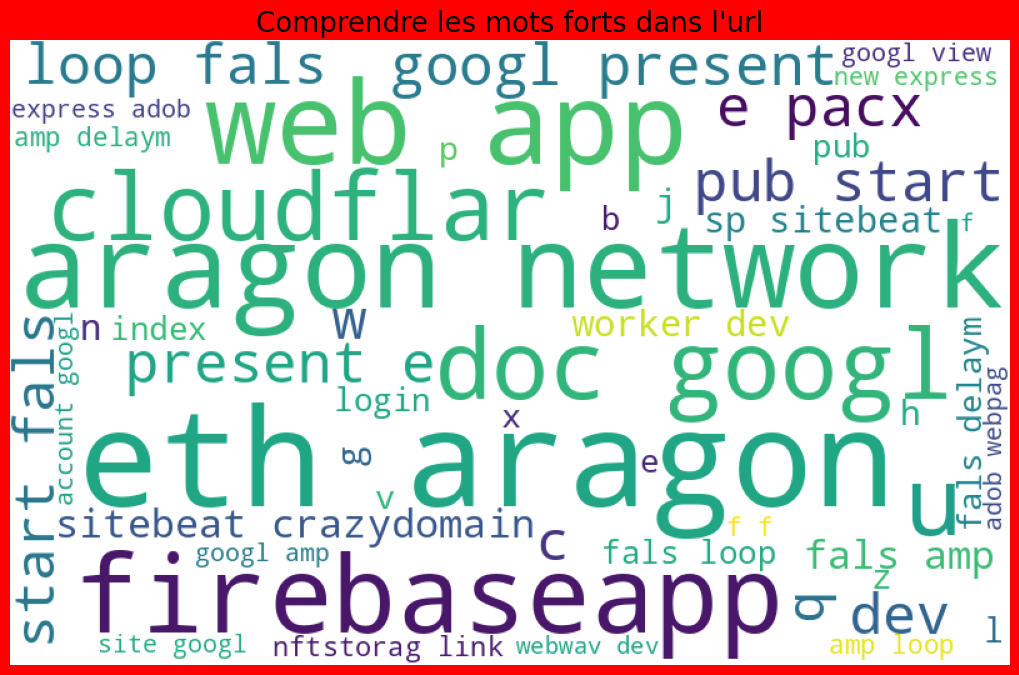

In [ ]:

phishing = bad_sites['text_sent']

# Création d'un objet WordCloud avec des paramètres spécifiés
phishing_cloud = WordCloud(
    width=800, height=500, background_color='white', max_words=50
).generate(' '.join(phishing))

# Configuration de la taille de la figure du graphique et de la couleur de fond
plt.figure(figsize=(10, 8), facecolor='r')

# Affichage de l'image WordCloud
plt.imshow(phishing_cloud)

# Ajout d'un titre au graphique
plt.title("Comprendre les mots forts dans l'url", fontsize=20)

# Désactivation des étiquettes des axes
plt.axis('off')

# Ajustement de la mise en page pour une meilleure apparence
plt.tight_layout(pad=0)

# Affichage du graphique
plt.show()

## Vectoriser les données

In [ ]:
# Créer une instance du vectoriseur TF-IDF
vectorizer = TfidfVectorizer()

In [ ]:

# Appliquer le vectoriseur aux données textuelles de la colonne 'text_sent'
feature = vectorizer.fit_transform(df_phish_processed['text_sent'])

# Tester et évaluer les modèles

In [ ]:
# Define report generator

def generer_rapport(matrice_confusion, score, rapport_classification):
    """
    Génère et affiche des rapports graphiques
    Arguments par mot-clé :
        matrice_confusion - Matrice de confusion générée par le modèle
        score --- Score généré par le modèle
        rapport_classification - Rapport de classification généré par le modèle

    """

    # Générer la carte thermique de la matrice de confusion
    plt.figure(figsize=(5, 5))
    sns.heatmap(matrice_confusion,
                annot=True,
                fmt="d",
                linewidths=.5,
                square=True,
                cmap='viridis',
                annot_kws={"size": 13},
                xticklabels=['fishing', 'legit'],
                yticklabels=['fishing', 'legit'])

    plt.xticks(rotation='horizontal', fontsize=13)
    plt.yticks(rotation='horizontal', fontsize=13)
    plt.xlabel('Étiquette Réelle', size=10);
    plt.ylabel('Étiquette Prédite', size=10);

    titre = 'Score de Précision : {0:.4f}'.format(score)
    plt.title(titre, size=15);

    # Afficher le rapport de classification et la matrice de confusion
    print(rapport_classification)
    plt.show()


## Importation des modèles

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Division des données

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(feature, df_phish_processed.label, test_size=0.2, random_state=42)

####  LogisticRegression

In [ ]:
# Créer une instance du modèle LogisticRegression
model_lr = LogisticRegression()

# Définir la validation croisée RepeatedStratifiedKFold
cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Liste pour stocker les résultats d'accuracy
accuracies = []

# Effectuer la validation croisée
for train_index, test_index in cv_lr.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Ajuster le modèle sur le fold d'entraînement
    model_lr.fit(X_train_fold, y_train_fold)

    # Prédire sur le fold de validation
    predictions_fold = model_lr.predict(X_val_fold)

    # Calculer l'accuracy sur le fold de validation
    fold_accuracy = accuracy_score(y_val_fold, predictions_fold)
    accuracies.append(fold_accuracy)

In [ ]:
# Afficher la moyenne des accuracies sur les différents folds
print("Moyenne des accuracies:", np.mean(accuracies))

Moyenne des accuracies: 0.9389412488001212


In [ ]:
# Tester le modèle sur l'ensemble de test
predictions_lr_test = model_lr.predict(X_test)
score_lr_test = accuracy_score(y_test, predictions_lr_test)
cmatrix_lr_test = confusion_matrix(y_test, predictions_lr_test)
creport_lr_test = classification_report(y_test, predictions_lr_test)

Evaluation
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3519
           1       1.00      0.77      0.87      1186

    accuracy                           0.94      4705
   macro avg       0.96      0.89      0.92      4705
weighted avg       0.95      0.94      0.94      4705



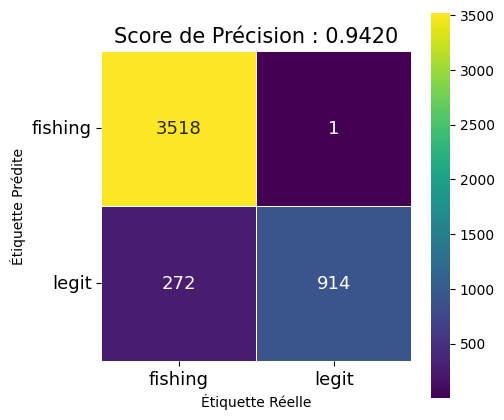

In [ ]:
print("Evaluation")
generer_rapport(cmatrix_lr_test, score_lr_test, creport_lr_test)

#### DecisionTreeClassifier

In [ ]:
# Créer une instance du modèle DecisionTreeClassifier avec des hyperparamètres spécifiés
model_dt = DecisionTreeClassifier(
    criterion='gini',       # Critère de sélection des features ('gini' ou 'entropy')
    splitter='best',        # Stratégie utilisée pour choisir la division à chaque noeud ('best' ou 'random')
    max_depth=None,         # Profondeur maximale de l'arbre (None signifie aucune limite)
    min_samples_split=2,    # Nombre minimum d'échantillons requis pour diviser un nœud interne
    min_samples_leaf=1,     # Nombre minimum d'échantillons requis pour être une feuille
    max_features=None,      # Nombre de fonctionnalités à considérer pour la meilleure division
    random_state=42
)

# Définir la validation croisée RepeatedStratifiedKFold
cv_dt = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Liste pour stocker les résultats d'accuracy
accuracies_dt = []

# Effectuer la validation croisée
for train_index, test_index in cv_dt.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Ajuster le modèle sur le fold d'entraînement
    model_dt.fit(X_train_fold, y_train_fold)

    # Prédire sur le fold de validation
    predictions_fold_dt = model_dt.predict(X_val_fold)

    # Calculer l'accuracy sur le fold de validation
    fold_accuracy_dt = accuracy_score(y_val_fold, predictions_fold_dt)
    accuracies_dt.append(fold_accuracy_dt)

# Afficher les accuracies de chaque fold
print("Accuracies for each fold with DecisionTreeClassifier:", accuracies_dt)


Accuracies for each fold with DecisionTreeClassifier: [0.9824654622741764, 0.9840595111583422, 0.9819341126461212, 0.9832580387988307, 0.9837895296306138, 0.9883103081827843, 0.9840595111583422, 0.9808714133900106, 0.9798033483922403, 0.9840552750465055, 0.9800743889479278, 0.9821997874601488, 0.9795430393198725, 0.9837895296306138, 0.9848525112941802]


In [ ]:
# Afficher la moyenne des accuracies sur les différents folds
print("Moyenne des accuracies:", np.mean(accuracies_dt))

Moyenne des accuracies: 0.9828710511553808


In [ ]:
# Tester le meilleur modèle sur l'ensemble de test
predictions_rf_test = model_dt.predict(X_test)
score_rf_test = accuracy_score(y_test, predictions_rf_test)
cmatrix_rf_test = confusion_matrix(y_test, predictions_rf_test)
creport_rf_test = classification_report(y_test, predictions_rf_test)

Evaluation
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3519
           1       0.96      0.98      0.97      1186

    accuracy                           0.98      4705
   macro avg       0.98      0.98      0.98      4705
weighted avg       0.98      0.98      0.98      4705



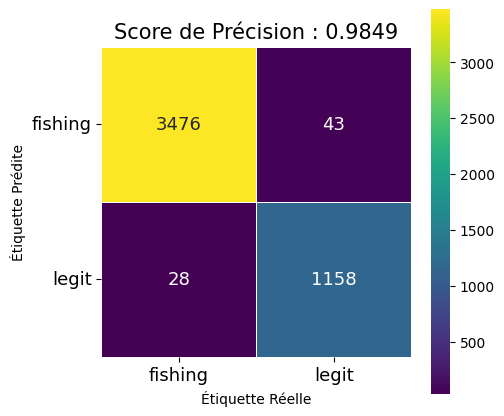

In [ ]:
print("Evaluation")
generer_rapport(cmatrix_rf_test, score_rf_test, creport_rf_test)

#### MultinomialNB

In [ ]:
# Définir le classificateur MultinomialNB
model_nb = MultinomialNB()


# Définir les hyperparamètres à tester
param_grid_nb = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0], 'fit_prior': [True, False]}

# Définir la validation croisée RepeatedStratifiedKFold
cv_nb = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Créer une instance du modèle MultinomialNB
model_nb = MultinomialNB()

# Créer l'instance GridSearchCV
grid_search_nb = GridSearchCV(estimator=model_nb, param_grid=param_grid_nb, cv=cv_nb, scoring='accuracy', n_jobs=-1)

# Ajuster le modèle avec GridSearchCV sur les données d'entraînement
grid_result_nb = grid_search_nb.fit(X_train, y_train)

# Obtenir le meilleur modèle
best_model_nb = grid_result_nb.best_estimator_

# Tester le meilleur modèle sur l'ensemble de test
predictions_nb_test = best_model_nb.predict(X_test)
score_nb_test = accuracy_score(y_test, predictions_nb_test)

In [ ]:
# Afficher les résultats sur l'ensemble de test
print("Meilleur modèle MultinomialNB - Résultats sur l'ensemble de test:")
print("Accuracy sur l'ensemble de test:", score_nb_test)

Meilleur modèle MultinomialNB - Résultats sur l'ensemble de test:
Accuracy sur l'ensemble de test: 0.9849096705632306


In [ ]:
# Tester le meilleur modèle sur l'ensemble de test
predictions_nb_test = best_model_nb.predict(X_test)
score_nb_test = accuracy_score(y_test, predictions_nb_test)
cmatrix_nb_test = confusion_matrix(y_test, predictions_nb_test)
creport_nb_test = classification_report(y_test, predictions_nb_test)

Evaluation
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3519
           1       0.99      0.95      0.97      1186

    accuracy                           0.98      4705
   macro avg       0.99      0.97      0.98      4705
weighted avg       0.98      0.98      0.98      4705



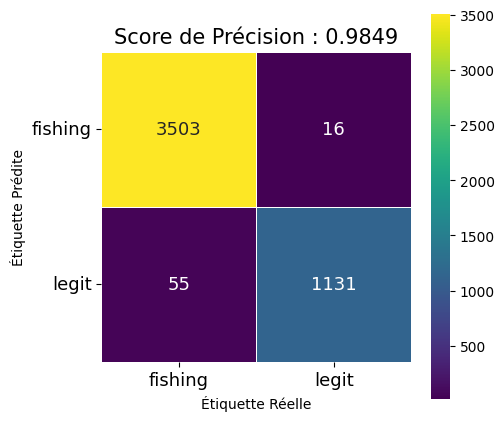

In [ ]:
print("Evaluation")
generer_rapport(cmatrix_nb_test, score_nb_test, creport_nb_test)

## Autres techniques (optionnelles)

#### Bagging

In [ ]:
# Initialisez vos modèles
random_forest = RandomForestClassifier(n_estimators=100, max_depth=3)
decision_tree = DecisionTreeClassifier()
logistic_regression = LogisticRegression()
naive_bayes = MultinomialNB()

# Créez un ensemble de modèles
ensemble_model = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('dt', decision_tree),  # Remplacez 'svm' par 'dt'
    ('lr', logistic_regression),
    ('nb', naive_bayes)
], voting='soft')

# Entraînez l'ensemble sur vos données d'entraînement
ensemble_model.fit(X_train, y_train)

# Faites des prédictions
predictions = ensemble_model.predict(X_test)

# Évaluez la performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Ensemble Model: {accuracy}")


Accuracy of Ensemble Model: 0.9925611052072264


### Test sur de nouvelles donndonnées

In [ ]:
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

In [ ]:
# Assurez-vous de transformer les nouvelles données de la même manière que vos données d'entraînement
X_predict = vectorizer.transform(predict_bad)

# Effectuez la prédiction
predictions = xgb_model.predict(X_predict)

# Affichez les prédictions
print(predictions)

[1 0 0 0]


## Préduction du label - fichier de soumission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ProjetData354/Projet1/fishing-submission.csv')

In [ ]:
submission.head(3)

,id,url,label
0,30508,https://pub-54efd4aa11884bfb834031d41082f502.r...,NaN
1,1173,https://rectify-assets-dapps.firebaseapp.com/,NaN
2,2736,https://mynumbercardpoint-sounu-go.jp/,NaN


In [ ]:
# Supposons que 'url' est la colonne contenant les URL dans votre DataFrame
submission['text_sent'] = submission['url'].apply(preprocess_initial)

# Transformez les nouvelles données en utilisant le même vectorizer que celui utilisé pour les données d'entraînement
X_submission = vectorizer.transform(submission['text_sent'])

In [ ]:
submission.head(3)

,id,url,label,text_sent,prediction
0,30508,https://pub-54efd4aa11884bfb834031d41082f502.r...,NaN,pub efd aa bfb f r dev res,1
1,1173,https://rectify-assets-dapps.firebaseapp.com/,NaN,rectifi asset dapp firebaseapp,1
2,2736,https://mynumbercardpoint-sounu-go.jp/,NaN,mynumbercardpoint sounu go jp,1


In [ ]:
# Effectuez la prédiction
predictions_submission = model_dt.predict(X_submission)

# Ajoutez les prédictions au DataFrame de soumission
submission['prediction'] = predictions_submission

# Supprimez la colonne 'label' si elle existe
if 'label' in submission.columns:
    submission.drop('label', axis=1, inplace=True)

# Remplacez les valeurs dans la colonne 'prediction'
submission['prediction'] = submission['prediction'].map({0: 'légit', 1: 'phishing'})


# Enregistrez le DataFrame de soumission avec les prédictions au format CSV
submission.to_csv('/content/drive/MyDrive/ProjetData354/Projet1/fishing-submission-predictions.csv', index=False)

In [ ]:
# Affichez le DataFrame avec les prédictions
prediction = pd.read_csv('/content/drive/MyDrive/ProjetData354/Projet1/fishing-submission-predictions.csv')

In [ ]:
prediction.head(3)

,id,url,prediction
0,30508,https://pub-54efd4aa11884bfb834031d41082f502.r...,phishing
1,1173,https://rectify-assets-dapps.firebaseapp.com/,phishing
2,2736,https://mynumbercardpoint-sounu-go.jp/,phishing


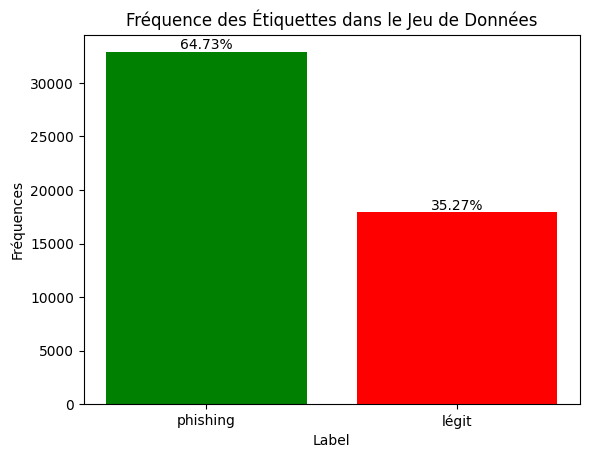

In [ ]:
# Extraction de la colonne des étiquettes du DataFrame
labels = prediction.prediction

# Création d'un nouveau DataFrame à partir de la colonne des étiquettes
labels = pd.DataFrame(labels)

# Calcul de la fréquence et du pourcentage des différentes étiquettes
labels_count = labels["prediction"].value_counts()
labels_percentage = labels_count / len(labels) * 100

# Affichage de la fréquence des étiquettes sous forme de diagramme à barres avec le pourcentage
fig, ax = plt.subplots()
bars = ax.bar(labels_count.index, labels_count.values, color=['red', 'green'])

# Ajout des étiquettes de pourcentage au-dessus des barres
for bar, percentage in zip(bars, labels_percentage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%',
            ha='center', va='bottom', fontsize=10, color='black')

# Configuration du diagramme
ax.set_xlabel("Label")  # Axe des x : Étiquettes
ax.set_ylabel("Fréquences")  # Axe des y : Fréquences
ax.set_title("Fréquence des Étiquettes dans le Jeu de Données")  # Titre du diagramme
plt.show()

#Mise en place d'un pipline

In [ ]:
from sklearn.pipeline import make_pipeline


# Instancier le vectorizer (TfidfVectorizer dans ce cas)
vectorizer = TfidfVectorizer(tokenizer=preprocess_initial)


# Créer le pipeline avec vectorizer et DecisionTreeClassifier
pipeline_ls = make_pipeline(
    vectorizer,
    DecisionTreeClassifier()
)

In [ ]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(df_phish.url, df_phish.label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(tokenizer=<function preprocess_initial at 0x7f83743becb0>)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [ ]:
pipeline_ls.score(testX,testY)

0.928413535113076

Training Accuracy : 1.0
Testing Accuracy : 0.928413535113076

CLASSIFICATION REPORT

              precision    recall  f1-score   support

     fishing       0.96      0.95      0.95      4489
       legit       0.84      0.86      0.85      1392

    accuracy                           0.93      5881
   macro avg       0.90      0.90      0.90      5881
weighted avg       0.93      0.93      0.93      5881


CONFUSION MATRIX


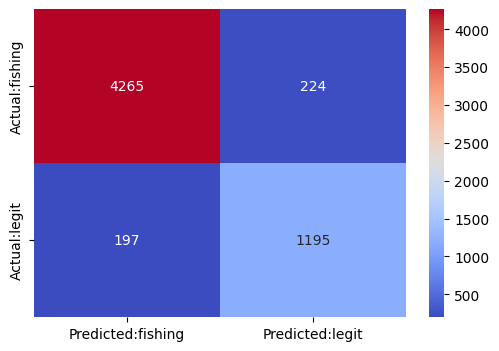

In [ ]:
# Évaluation des performances du modèle sur les données d'entraînement
print('Training Accuracy :', pipeline_ls.score(trainX, trainY))

# Évaluation des performances du modèle sur les données de test
print('Testing Accuracy :', pipeline_ls.score(testX, testY))

# Calcul de la matrice de confusion sur les données de test
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns=['Predicted:fishing', 'Predicted:legit'],
            index=['Actual:fishing', 'Actual:legit'])

# Affichage du rapport de classification
print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names=['fishing', 'legit']))

# Affichage de la matrice de confusion sous forme de figure
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap="coolwarm")

# Affichage de la figure
plt.show()

In [ ]:
import pickle


pickle.dump(pipeline_ls,open('/content/drive/MyDrive/ProjetData354/Projet1/phishingDT.pkl','wb'))


In [ ]:
loaded_model = pickle.load(open('/content/drive/MyDrive/ProjetData354/Projet1/phishingDT.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.928413535113076


In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('/content/drive/MyDrive/ProjetData354/Projet1/phishingDT.pkl', 'rb'))
# predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("-"*40)
print(result2)

[0 0 1 0]
----------------------------------------
[1 0 1 1]


# Mise en production du modèle



 Cliquer ici pour faire des tests:
 # http://fotiemb.pythonanywhere.com/
